In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
from glob import glob

dir_path = "/content/drive/Shareddrives/Deep_Learning_A3/Datasets"

image_files = glob(os.path.join(dir_path, '**/*.jpg'), recursive=True) + \
              glob(os.path.join(dir_path, '**/*.jpeg'), recursive=True) + \
              glob(os.path.join(dir_path, '**/*.png'), recursive=True)

total_images = len(image_files)

print("Total number of images:", total_images)


Total number of images: 2748


In [3]:
import os
import numpy as np

from PIL import Image
from sklearn.model_selection import train_test_split

In [4]:
# This functions extract the images from all the subfolders in ImageClassification and put it in an array
def load_data(data_dir):
    images = []
    labels = [] 
    class_names = sorted(os.listdir(data_dir)) 
    for class_index, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name) 
        for file_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, file_name) 
            image = Image.open(image_path) 
            target_size = (224,224) # Resize the image to 224 * 224
            image = image.resize(target_size)
            image = np.array(image)
            images.append(image) 
            labels.append(class_index) 
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

In [5]:
path='/content/drive/Shareddrives/Deep_Learning_A3/Datasets'
images, labels = load_data(path)

In [6]:
print(np.shape(images)) #look at the dimension of the dataset
print(len(labels))
print(labels[1])

(2748, 224, 224, 3)
2748
0


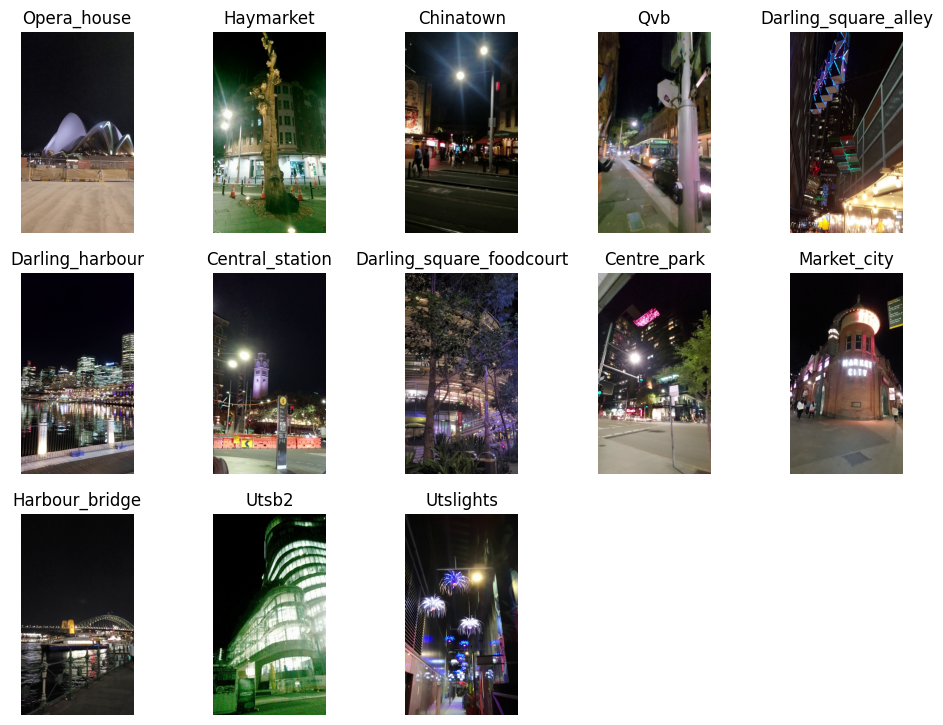

In [7]:
import matplotlib.pyplot as plt

# get the list of all subfolders
subfolders = os.listdir(path)

# create a figure object
fig = plt.figure(figsize=(12, 12))

# loop through all subfolders
for i, subfolder in enumerate(subfolders):
    # get the label name from the subfolder name
    label = subfolder.capitalize()  # assuming the subfolder name is in lowercase
    
    # get the path of all images in the subfolder
    img_paths = os.listdir(os.path.join(path, subfolder))
    
    # select the first image from the subfolder
    img_path = os.path.join(path, subfolder, img_paths[0])
    
    # load the image using PIL
    img = Image.open(img_path)
    
    # add the image to the figure
    ax = fig.add_subplot(4, 5, i+1)
    ax.imshow(img)
    ax.axis('off')
    
    # add the label to the image
    ax.set_title(label)

# display the figure
plt.show()

In [8]:
from tensorflow import keras

In [9]:
# Split the training set into training and training sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.4, random_state=42)

# Split the training set into training and validation sets
X_test, X_val, y_test, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=42)

# num_classes=13
# y_train = keras.utils.to_categorical(y_train, num_classes=num_classes)
# y_val = keras.utils.to_categorical(y_val, num_classes=num_classes)
# y_test = keras.utils.to_categorical(y_test, num_classes=num_classes)

In [10]:
# Check the size of the training, test, and validation set
print(len(X_train), len(X_test), len(X_val))

1648 824 824


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
# Image augmentation settings for the training set
train_datagen = ImageDataGenerator(
      rescale=1./255, # Normalisation
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest') #perform image augmentation

test_datagen =  ImageDataGenerator(rescale=1./255) # Normalisation

batch_size = 32

# Flow training images using train_datagen generator
train_generator = train_datagen.flow(
         X_train, y_train,
        batch_size=batch_size)

# Flow test images using test_datagen generator
test_generator = test_datagen.flow(
         X_test, y_test,
        batch_size=batch_size)

# Flow validation images using test_datagen generator
validation_generator = test_datagen.flow(
         X_val, y_val,
        batch_size=batch_size)

In [13]:
from keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, concatenate, Dropout
from keras.models import Model
from tensorflow.keras.layers import Activation

from tensorflow.keras.regularizers import l1 #l1 regularlizer

In [14]:
def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '/'
    x = Conv2D(squeeze, (1, 1), padding='valid', activation='relu', name=s_id + 'squeeze')(x)
    left = Conv2D(expand, (1, 1), padding='valid', activation='relu', name=s_id + 'expand1')(x)
    right = Conv2D(expand, (3, 3), padding='same', activation='relu', name=s_id + 'expand2')(x)
    x = concatenate([left, right], axis=3, name=s_id + 'concat')
    return x

def SqueezeNet(input_shape=(224,224,3), classes=1000):
    input_img = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), strides=(2, 2), padding='valid', activation='relu', name='conv1')(input_img)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='maxpool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='maxpool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='maxpool5')(x)

    x = fire_module(x, fire_id=6, squeeze=48, expand=192)

    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    x = fire_module(x, fire_id=9, squeeze=64, expand=256)
    x = Dropout(0.5, name='drop9')(x)

    x = Conv2D(classes, (1, 1), padding='valid', name='conv10')(x)
    x = GlobalAveragePooling2D()(x)
    out = Activation('softmax', name='softmax')(x)

    model = Model(inputs=input_img, outputs=out, name='squeezenet')

    return model


In [15]:
from tensorflow.keras.optimizers import Adam

model = SqueezeNet(input_shape=(224,224,3), classes=13)
model.compile(optimizer=Adam(lr=0.0001), loss='sparse_categorical_crossentropy', metrics=['acc'])

In [16]:
# model.summary()

In [17]:
history = model.fit(train_generator,
          validation_data = validation_generator,
          epochs =25)

Epoch 1/25
52/52 [==============================] - 35s 411ms/step - loss: 2.4675 - acc: 0.2451 - val_loss: 2.4077 - val_acc: 0.2354
Epoch 2/25
52/52 [==============================] - 21s 410ms/step - loss: 2.3717 - acc: 0.2506 - val_loss: 2.3423 - val_acc: 0.2354
Epoch 3/25
52/52 [==============================] - 19s 375ms/step - loss: 2.1452 - acc: 0.2834 - val_loss: 1.9768 - val_acc: 0.3786
Epoch 4/25
52/52 [==============================] - 25s 476ms/step - loss: 1.8840 - acc: 0.3762 - val_loss: 1.5551 - val_acc: 0.4150
Epoch 5/25
52/52 [==============================] - 19s 371ms/step - loss: 1.6732 - acc: 0.4199 - val_loss: 1.4588 - val_acc: 0.4818
Epoch 6/25
52/52 [==============================] - 21s 399ms/step - loss: 1.4059 - acc: 0.5079 - val_loss: 1.1449 - val_acc: 0.5947
Epoch 7/25
52/52 [==============================] - 20s 378ms/step - loss: 1.1574 - acc: 0.5765 - val_loss: 0.9563 - val_acc: 0.6626
Epoch 8/25
52/52 [==============================] - 22s 419ms/step - 

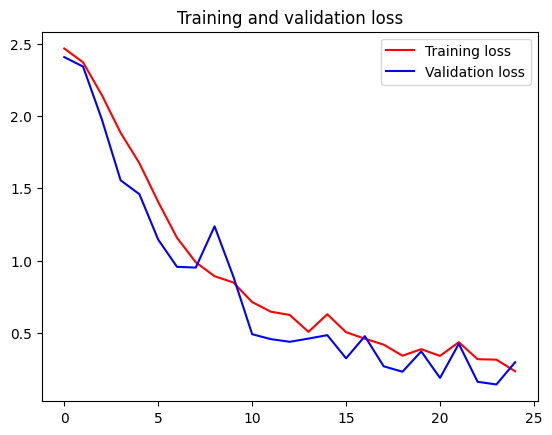

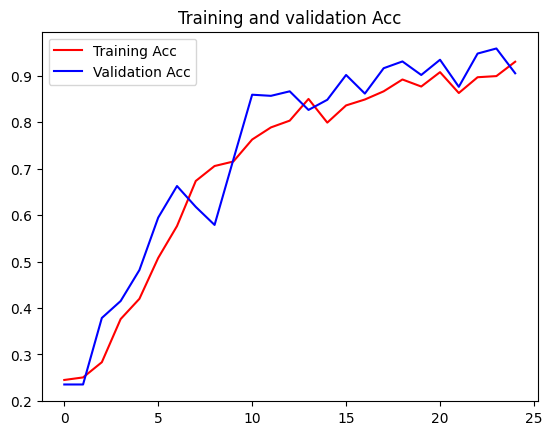

In [18]:
## Plot the Training and Validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

## Plot the Training and Validation acc
accu = history.history['acc']
val_accu = history.history['val_acc']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, accu, 'r', label='Training Acc')
plt.plot(epochs, val_accu, 'b', label='Validation Acc')
plt.title('Training and validation Acc')
plt.legend()

In [19]:
y_pred = model.predict(X_test)

26/26 [==============================] - 1s 14ms/step


In [20]:
import cv2
from sklearn.metrics import accuracy_score


In [21]:
# # get predictions for X_test
# y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
# y_pred_ohe = keras.utils.to_categorical(y_pred_classes, num_classes=num_classes)

# # calculate accuracy
accuracy = accuracy_score(y_test, y_pred_classes)

print(f"Prediction Accuracy: {accuracy}")
# pred_labels = model.predict(X_test)

test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

Prediction Accuracy: 0.05218446601941747
26/26 [==============================] - 1s 17ms/step - loss: 1992.8101 - acc: 0.0522
Test accuracy: 0.052184466272592545


In [22]:
import os

# Set the path to the directory containing the subfolders
data_dir = '/content/drive/Shareddrives/Deep_Learning_A3/Datasets'

# Get the subfolder names
class_names = os.listdir(data_dir)

# Print the class names
print(class_names)

['Opera_House', 'Haymarket', 'Chinatown', 'QVB', 'Darling_Square_Alley', 'Darling_Harbour', 'Central_Station', 'Darling_Square_FoodCourt', 'Centre_Park', 'Market_City', 'Harbour_Bridge', 'UTSB2', 'UTSLIGHTS']


In [23]:
images = []
orig_label = []

for i in np.random.choice(np.arange(0, len(y_test)), size=(16,)):
    label = y_pred[i]
    orig_label.append(y_test[i])
    image = X_test[i]

    color = (0, 255, 0)
    
    # convert the image to a 3-channel image
    if image.shape[-1] > 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)
        
    image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)
    cv2.putText(image, str(np.argmax(label)), (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.50, color, 2)
    images.append(image)


9
9
6
9


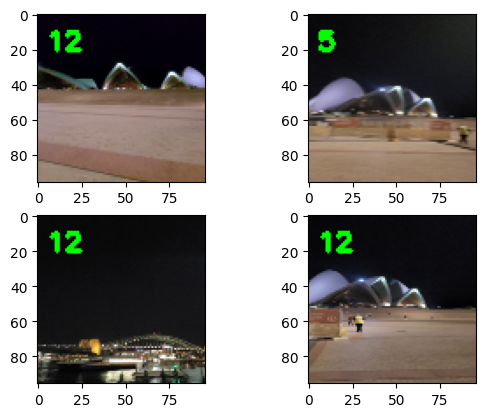

In [24]:
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(images[1])
print(orig_label[1])
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(images[2])
print(orig_label[2])
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(images[3])
print(orig_label[3])
ax4 = fig.add_subplot(2,2,4)
ax4.imshow(images[4])
print(orig_label[4])